In [1]:
import numpy as np
import os
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torchvision.utils import make_grid
import torchvision.models as models
import matplotlib.pyplot as plt
import seaborn as sns
import random
from copy import deepcopy
from torchsummary import summary

In [2]:
ds_path = "datasets/Intel Image Classification/"
train_path = os.path.join(ds_path, "seg_train")
test_path = os.path.join(ds_path, "seg_test")

classes = os.listdir(train_path)
classes 

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [3]:
BATCHSIZE = 32
N_WORKERS = 2

In [4]:
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),          
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
])

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

full_train_ds = datasets.ImageFolder(root=train_path, transform=test_transform)
test_ds = datasets.ImageFolder(root=test_path, transform=test_transform)

train_ds, val_ds = random_split(full_train_ds, [0.8, 0.2])
train_ds.dataset = deepcopy(train_ds.dataset)
train_ds.dataset.transform = train_transform

In [5]:
test_loader = DataLoader(test_ds, batch_size=BATCHSIZE, num_workers=N_WORKERS, shuffle=False)
train_loader = DataLoader(train_ds, batch_size=BATCHSIZE, num_workers=N_WORKERS, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCHSIZE, num_workers=N_WORKERS, shuffle=False)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
def train_model(model, train_loader, val_loader, n_epochs=10, print_progress=True, dynamic_lr=False, scheduler=None, unfreeze=False, unfreezer=None):

    train_losses, train_accs, train_f1s = [], [], []
    val_losses, val_accs, val_f1s = [], [], []
    
    for epoch in range(n_epochs):
        ### --- TRAINING PHASE --- ###
        model.train()
        train_loss = 0.0
        y_true_train = np.zeros(len(train_ds), dtype=int)
        y_pred_train = np.zeros(len(train_ds), dtype=int)

        index = 0
        for images, labels in train_loader:
            batch_size = labels.size(0) 
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Track statistics
            train_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            y_true_train[index : index + batch_size] = labels.cpu().numpy()
            y_pred_train[index : index + batch_size] = predicted.cpu().numpy()
            index += batch_size
            
        train_acc = accuracy_score(y_true_train, y_pred_train)
        train_f1 = f1_score(y_true_train, y_pred_train, average="weighted")
        
        train_loss = train_loss/len(train_ds)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        train_f1s.append(train_f1)
        
        ### --- VALIDATION PHASE --- ###
        model.eval()
        val_loss = 0.0
        y_true_val = np.zeros(len(val_ds), dtype=int)
        y_pred_val = np.zeros(len(val_ds), dtype=int)
        with torch.no_grad():  
            index = 0
            for images, labels in val_loader:
                batch_size = labels.size(0) 
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                y_true_val[index : index + batch_size] = labels.cpu().numpy()
                y_pred_val[index : index + batch_size] = predicted.cpu().numpy()
                index += batch_size

        val_acc = accuracy_score(y_true_val, y_pred_val)
        val_f1 = f1_score(y_true_val, y_pred_val, average="weighted")

        val_loss = val_loss/len(val_ds)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        val_f1s.append(val_f1)

        if dynamic_lr:
            scheduler.step()
            #print(f"Current LR: {optimizer.param_groups[0]['lr']:.6f}")

        if unfreeze:
            unfreezer(model, epoch)
            
        if print_progress:
            print(f"Epoch [{epoch+1}/{n_epochs}]: "
                  f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f} | "
                  f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}")
    
    if print_progress:
        print("Training Complete!")
    return train_losses, train_accs, train_f1s, val_losses, val_accs, val_f1s


In [8]:
def visualize_scores(metrics):
    # Unpack metrics
    train_losses, train_accs, train_f1s, val_losses, val_accs, val_f1s = metrics
    epochs = range(1, len(train_losses) + 1)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plot Loss
    axes[0].plot(epochs, train_losses, label="Train Loss")
    axes[0].plot(epochs, val_losses, label="Val Loss")
    axes[0].set_title("Loss")
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Loss")
    axes[0].grid(visible=True)
    axes[0].legend()

    # Plot Accuracy
    axes[1].plot(epochs, train_accs, label="Train Accuracy")
    axes[1].plot(epochs, val_accs, label="Val Accuracy")
    axes[1].set_title("Accuracy")
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Accuracy")
    axes[1].grid(visible=True)
    axes[1].legend()

    # Plot F1-score
    axes[2].plot(epochs, train_f1s, label="Train F1-score")
    axes[2].plot(epochs, val_f1s, label="Val F1-score")
    axes[2].set_title("F1-score")
    axes[2].set_xlabel("Epochs")
    axes[2].set_ylabel("F1-score")
    axes[2].grid(visible=True)
    axes[2].legend()

    plt.tight_layout()
    plt.show()


In [9]:
def conf_matrices(y_true_train, y_pred_train, y_true_val, y_pred_val, class_names):
    # Compute confusion matrices
    cm_train = confusion_matrix(y_true_train, y_pred_train)
    cm_val = confusion_matrix(y_true_val, y_pred_val)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Plot Train Confusion Matrix
    sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names, ax=axes[0])
    axes[0].set_title("Train Confusion Matrix")
    axes[0].set_xlabel("Predicted Labels")
    axes[0].set_ylabel("True Labels")

    # Plot Validation Confusion Matrix
    sns.heatmap(cm_val, annot=True, fmt="d", cmap="Oranges", xticklabels=class_names, yticklabels=class_names, ax=axes[1])
    axes[1].set_title("Validation Confusion Matrix")
    axes[1].set_xlabel("Predicted Labels")
    axes[1].set_ylabel("True Labels")

    plt.tight_layout()
    plt.show()


In [10]:
def get_predictions(model, dataloader):

    model.eval()  
    y_true = []
    y_pred = []

    with torch.no_grad():  
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)  
            outputs = model(images)  
            _, predicted = torch.max(outputs, 1)  
            
            y_true.extend(labels.cpu().numpy())  
            y_pred.extend(predicted.cpu().numpy())  

    return np.array(y_true), np.array(y_pred)

In [11]:
def visualize(model, metrics):
        visualize_scores(metrics)
        val_true, val_pred = get_predictions(model, val_loader)
        train_true, train_pred = get_predictions(model, train_loader)
        conf_matrices(train_true, train_pred, val_true, val_pred, classes)

In [12]:
model = models.resnet50(weights="IMAGENET1K_V2").to(device)

In [13]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [14]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [15]:
for param in model.parameters():
        param.requires_grad = False


In [16]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [17]:
model.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [18]:
model.fc = nn.Linear(2048, 6)
model.fc

Linear(in_features=2048, out_features=6, bias=True)

In [19]:
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-4)

In [20]:
%%time 
EPOCHS = 5
metrics = train_model(model, train_loader, val_loader, EPOCHS)

Epoch [1/5]: Train Loss: 1.2261, Train Acc: 0.72 | Val Loss: 0.8535, Val Acc: 0.84
Epoch [2/5]: Train Loss: 0.7246, Train Acc: 0.85 | Val Loss: 0.6100, Val Acc: 0.86
Epoch [3/5]: Train Loss: 0.5659, Train Acc: 0.86 | Val Loss: 0.4801, Val Acc: 0.87
Epoch [4/5]: Train Loss: 0.4851, Train Acc: 0.87 | Val Loss: 0.4518, Val Acc: 0.88
Epoch [5/5]: Train Loss: 0.4314, Train Acc: 0.88 | Val Loss: 0.3930, Val Acc: 0.88
Training Complete!
CPU times: total: 30min 22s
Wall time: 7min 39s


In [21]:
def unfreezer(model, epoch):
    layers = [model.layer4, model.layer3, model.layer2, model.layer1]
    if (epoch+1)%5 == 0 and epoch<20:
        for param in layers[epoch//5].parameters():
            param.requires_grad = True

In [22]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.25)

In [23]:
%%time
EPOCHS = 25
metrics2 = train_model(model, train_loader, val_loader, EPOCHS, dynamic_lr=True, scheduler=scheduler, unfreeze=True, unfreezer=unfreezer)

Epoch [1/25]: Train Loss: 0.3966, Train Acc: 0.88 | Val Loss: 0.3785, Val Acc: 0.89
Epoch [2/25]: Train Loss: 0.3696, Train Acc: 0.89 | Val Loss: 0.3362, Val Acc: 0.90
Epoch [3/25]: Train Loss: 0.3500, Train Acc: 0.89 | Val Loss: 0.3269, Val Acc: 0.90
Epoch [4/25]: Train Loss: 0.3367, Train Acc: 0.89 | Val Loss: 0.3181, Val Acc: 0.89
Epoch [5/25]: Train Loss: 0.3269, Train Acc: 0.89 | Val Loss: 0.3042, Val Acc: 0.91
Epoch [6/25]: Train Loss: 0.2691, Train Acc: 0.91 | Val Loss: 0.2332, Val Acc: 0.92
Epoch [7/25]: Train Loss: 0.2109, Train Acc: 0.93 | Val Loss: 0.2120, Val Acc: 0.93
Epoch [8/25]: Train Loss: 0.1806, Train Acc: 0.94 | Val Loss: 0.1994, Val Acc: 0.93
Epoch [9/25]: Train Loss: 0.1585, Train Acc: 0.94 | Val Loss: 0.1941, Val Acc: 0.93
Epoch [10/25]: Train Loss: 0.1371, Train Acc: 0.95 | Val Loss: 0.1884, Val Acc: 0.93
Epoch [11/25]: Train Loss: 0.1176, Train Acc: 0.96 | Val Loss: 0.1883, Val Acc: 0.94
Epoch [12/25]: Train Loss: 0.1051, Train Acc: 0.96 | Val Loss: 0.1852, Val

In [26]:
metrics = list(metrics)
metrics2 = list(metrics2)
for i in range(6):
    metrics[i] = metrics[i] + metrics2[i]

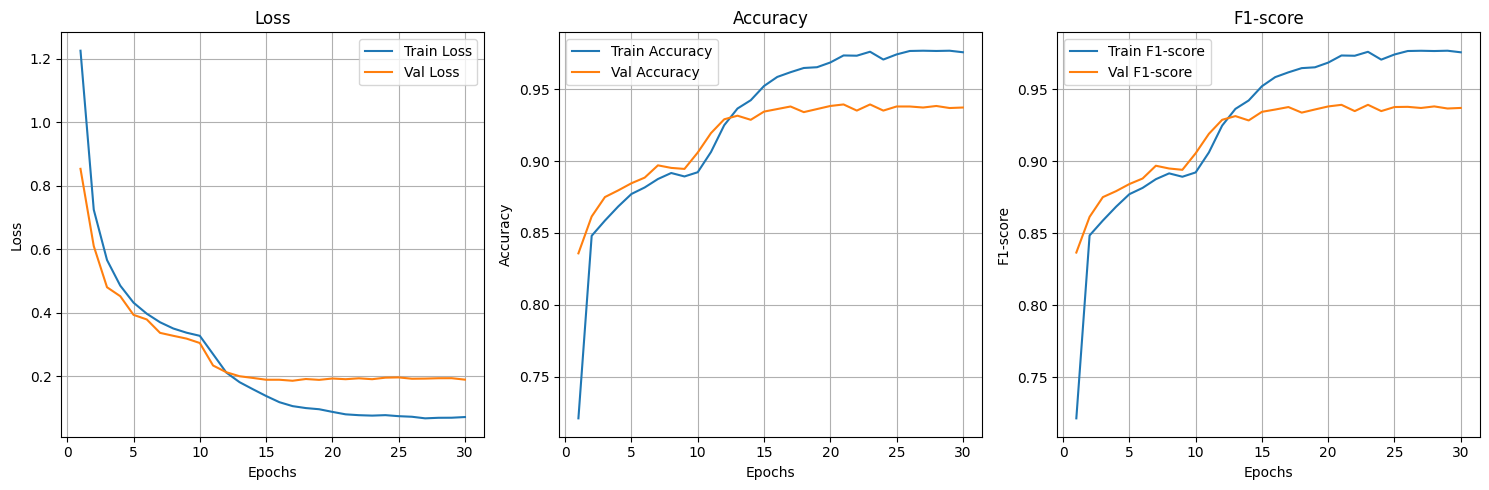

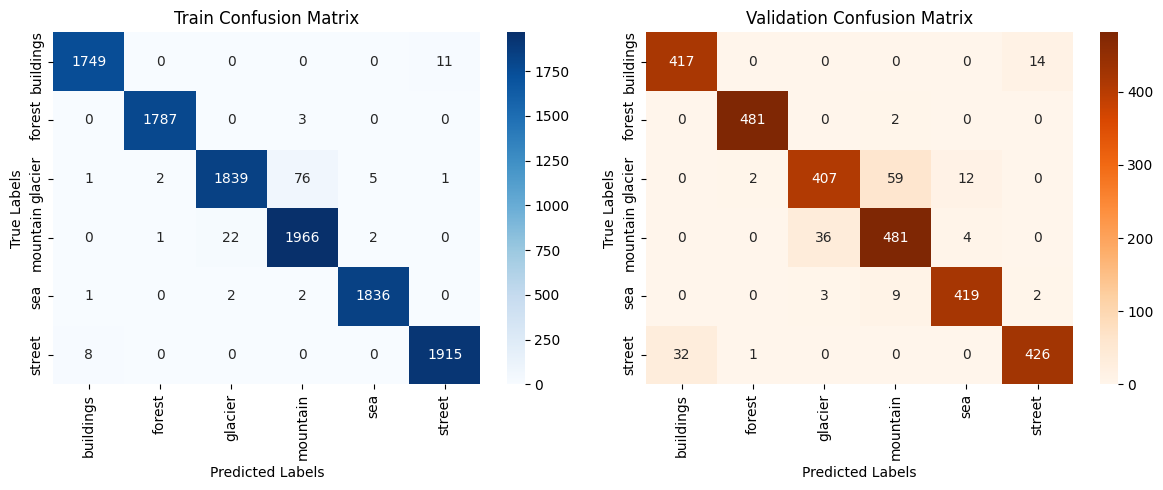

In [27]:
visualize(model, metrics)

In [28]:
# torch.save({
#     'model_state_dict': model.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict(),
#     'metrics': metrics
# }, 'models/pretr_v1.pth')

# V1

In [26]:
checkpoint = torch.load('models/pretr_v1.pth', weights_only=False)
model = models.resnet50(weights="IMAGENET1K_V2")
model.fc = nn.Linear(model.fc.in_features, 6)
metrics = checkpoint['metrics']
model.load_state_dict(checkpoint['model_state_dict'])


<All keys matched successfully>

In [27]:
model.fc = nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(model.fc.in_features, 6)
)

In [28]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [43]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

In [44]:
%%time
EPOCHS = 10
metrics2 = train_model(model, train_loader, val_loader, EPOCHS)

Epoch [1/10]: Train Loss: 0.9449, Train Acc: 0.79 | Val Loss: 0.3325, Val Acc: 0.93
Epoch [2/10]: Train Loss: 0.2606, Train Acc: 0.93 | Val Loss: 0.2051, Val Acc: 0.94
Epoch [3/10]: Train Loss: 0.1917, Train Acc: 0.94 | Val Loss: 0.1834, Val Acc: 0.94
Epoch [4/10]: Train Loss: 0.1568, Train Acc: 0.95 | Val Loss: 0.1774, Val Acc: 0.94
Epoch [5/10]: Train Loss: 0.1294, Train Acc: 0.96 | Val Loss: 0.1843, Val Acc: 0.94
Epoch [6/10]: Train Loss: 0.1132, Train Acc: 0.96 | Val Loss: 0.1804, Val Acc: 0.94
Epoch [7/10]: Train Loss: 0.0996, Train Acc: 0.97 | Val Loss: 0.1813, Val Acc: 0.94
Epoch [8/10]: Train Loss: 0.0908, Train Acc: 0.97 | Val Loss: 0.1886, Val Acc: 0.94
Epoch [9/10]: Train Loss: 0.0718, Train Acc: 0.98 | Val Loss: 0.1915, Val Acc: 0.94
Epoch [10/10]: Train Loss: 0.0598, Train Acc: 0.98 | Val Loss: 0.1990, Val Acc: 0.94
Training Complete!
CPU times: total: 1h 15min 13s
Wall time: 27min 1s


In [45]:
metrics = list(metrics)
metrics2 = list(metrics2)
for i in range(6):
    metrics[i] = metrics[i] + metrics2[i]

In [47]:
model.fc = nn.Sequential(
    nn.Dropout(p=0.4),
    nn.Linear(2048, 6)
)
model = model.to(device)

In [49]:
%%time
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.7)
EPOCHS = 10
metrics2 = train_model(model, train_loader, val_loader, EPOCHS, dynamic_lr=True, scheduler=scheduler)

Epoch [1/10]: Train Loss: 0.5566, Train Acc: 0.90 | Val Loss: 0.2126, Val Acc: 0.94
Epoch [2/10]: Train Loss: 0.1486, Train Acc: 0.97 | Val Loss: 0.1859, Val Acc: 0.94
Epoch [3/10]: Train Loss: 0.1070, Train Acc: 0.97 | Val Loss: 0.1929, Val Acc: 0.94
Epoch [4/10]: Train Loss: 0.0853, Train Acc: 0.98 | Val Loss: 0.1952, Val Acc: 0.94
Epoch [5/10]: Train Loss: 0.0721, Train Acc: 0.98 | Val Loss: 0.1983, Val Acc: 0.94
Epoch [6/10]: Train Loss: 0.0646, Train Acc: 0.98 | Val Loss: 0.2068, Val Acc: 0.94
Epoch [7/10]: Train Loss: 0.0570, Train Acc: 0.98 | Val Loss: 0.2153, Val Acc: 0.94
Epoch [8/10]: Train Loss: 0.0542, Train Acc: 0.99 | Val Loss: 0.2074, Val Acc: 0.94
Epoch [9/10]: Train Loss: 0.0484, Train Acc: 0.99 | Val Loss: 0.2113, Val Acc: 0.94
Epoch [10/10]: Train Loss: 0.0452, Train Acc: 0.99 | Val Loss: 0.2189, Val Acc: 0.94
Training Complete!
CPU times: total: 1h 19min 36s
Wall time: 28min 9s


In [50]:
metrics = list(metrics)
metrics2 = list(metrics2)
for i in range(6):
    metrics[i] = metrics[i] + metrics2[i]

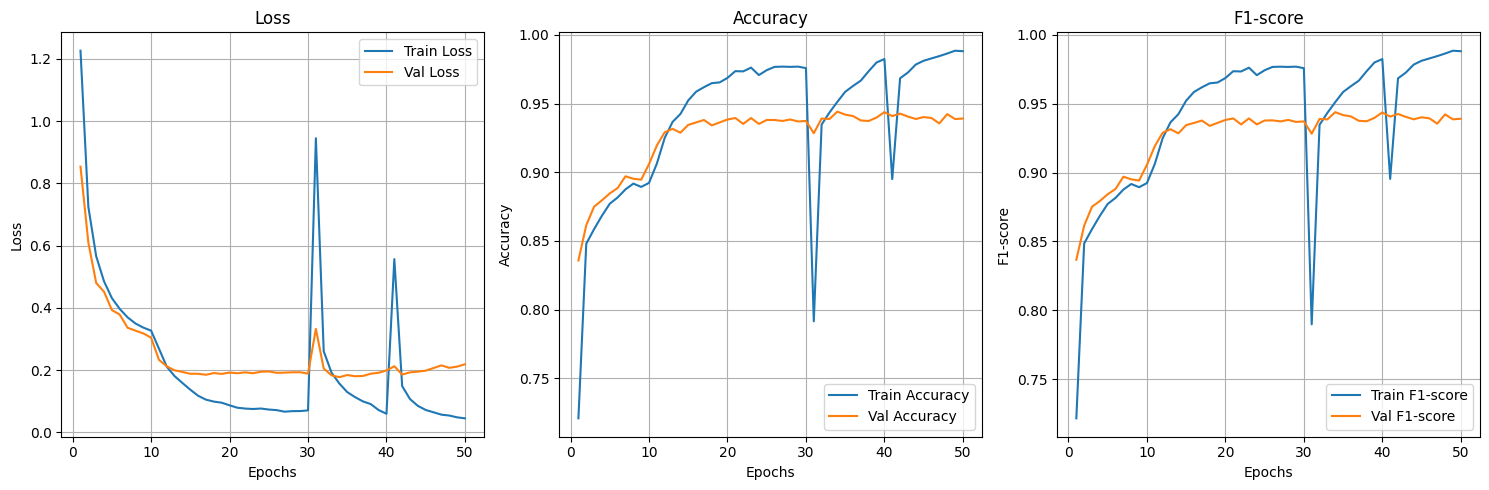

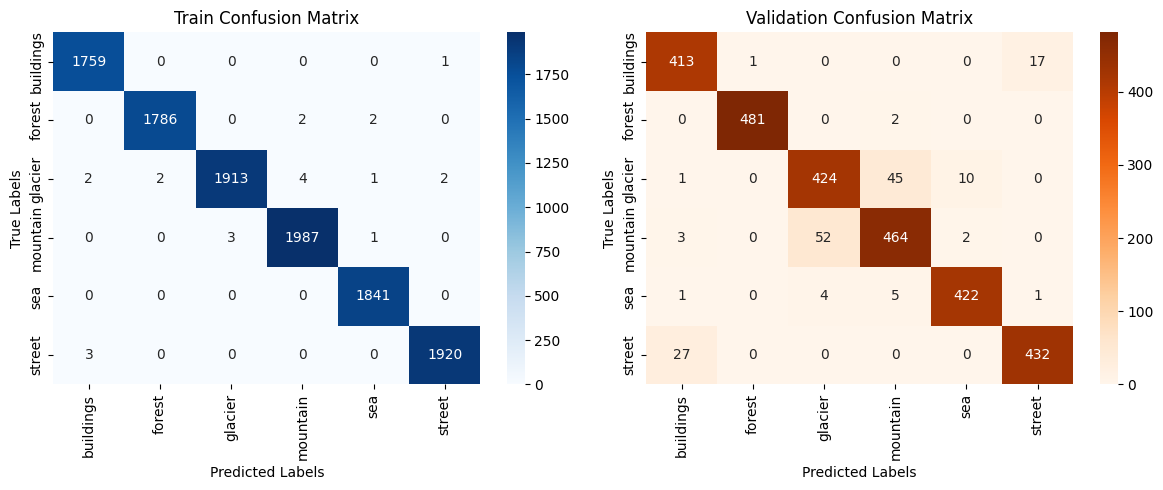

In [51]:
visualize(model, metrics)

# V2

In [13]:
checkpoint = torch.load('models/pretr_v1.pth', weights_only=False)
metrics = checkpoint['metrics']

In [14]:
model = models.resnet50(weights="IMAGENET1K_V2")
model.fc = nn.Linear(model.fc.in_features, 6)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [15]:
model.fc = nn.Sequential(
    nn.Dropout(p=0.3),
    nn.Linear(model.fc.in_features, 6)
)

In [20]:
heavy_transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ColorJitter(0.3, 0.3, 0.3),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomAffine(degrees=30, scale=(0.9, 1.1), shear=10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,), (0.5,))
])

train_ds.dataset.transform = heavy_transform

In [21]:
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.8)
criterion = nn.CrossEntropyLoss()

In [22]:
%%time
EPOCHS = 20
metrics2 = train_model(model, train_loader, val_loader, EPOCHS, dynamic_lr=True, scheduler=scheduler)

Epoch [1/20]: Train Loss: 1.1541, Train Acc: 0.68 | Val Loss: 0.4016, Val Acc: 0.94
Epoch [2/20]: Train Loss: 0.4206, Train Acc: 0.88 | Val Loss: 0.2124, Val Acc: 0.94
Epoch [3/20]: Train Loss: 0.3118, Train Acc: 0.90 | Val Loss: 0.1815, Val Acc: 0.94
Epoch [4/20]: Train Loss: 0.2730, Train Acc: 0.91 | Val Loss: 0.1632, Val Acc: 0.94
Epoch [5/20]: Train Loss: 0.2480, Train Acc: 0.91 | Val Loss: 0.1660, Val Acc: 0.94
Epoch [6/20]: Train Loss: 0.2322, Train Acc: 0.92 | Val Loss: 0.1544, Val Acc: 0.94
Epoch [7/20]: Train Loss: 0.2249, Train Acc: 0.92 | Val Loss: 0.1538, Val Acc: 0.95
Epoch [8/20]: Train Loss: 0.2103, Train Acc: 0.93 | Val Loss: 0.1501, Val Acc: 0.95
Epoch [9/20]: Train Loss: 0.2012, Train Acc: 0.93 | Val Loss: 0.1483, Val Acc: 0.95
Epoch [10/20]: Train Loss: 0.1974, Train Acc: 0.93 | Val Loss: 0.1462, Val Acc: 0.95
Epoch [11/20]: Train Loss: 0.1945, Train Acc: 0.93 | Val Loss: 0.1399, Val Acc: 0.95
Epoch [12/20]: Train Loss: 0.1850, Train Acc: 0.94 | Val Loss: 0.1476, Val

In [23]:
metrics = list(metrics)
metrics2 = list(metrics2)
for i in range(6):
    metrics[i] = metrics[i] + metrics2[i]

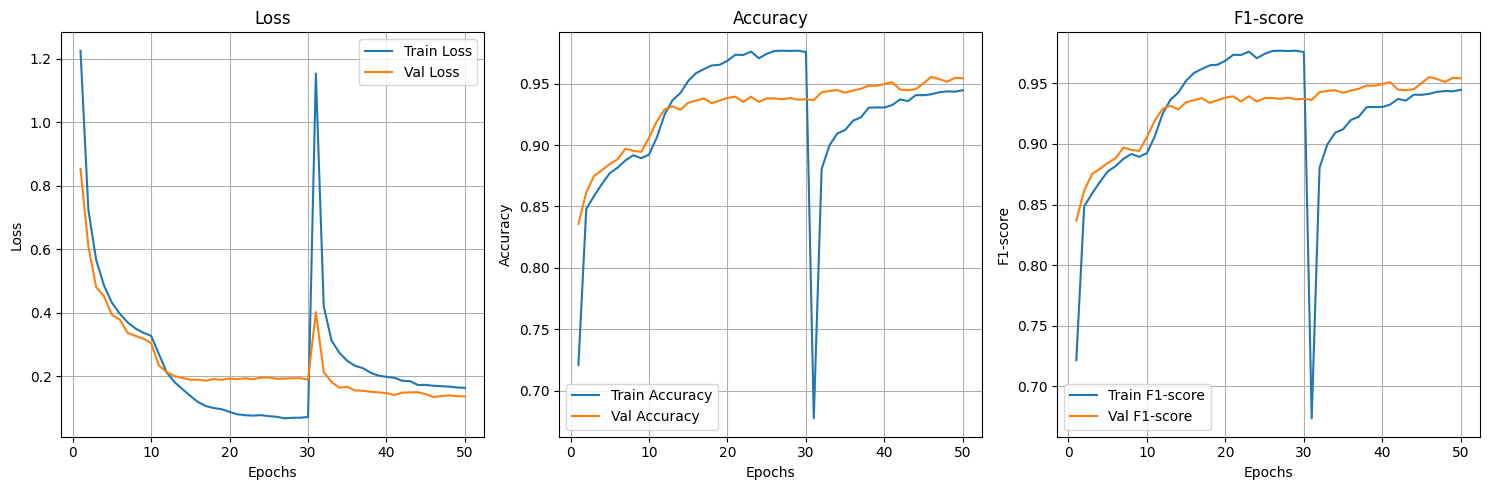

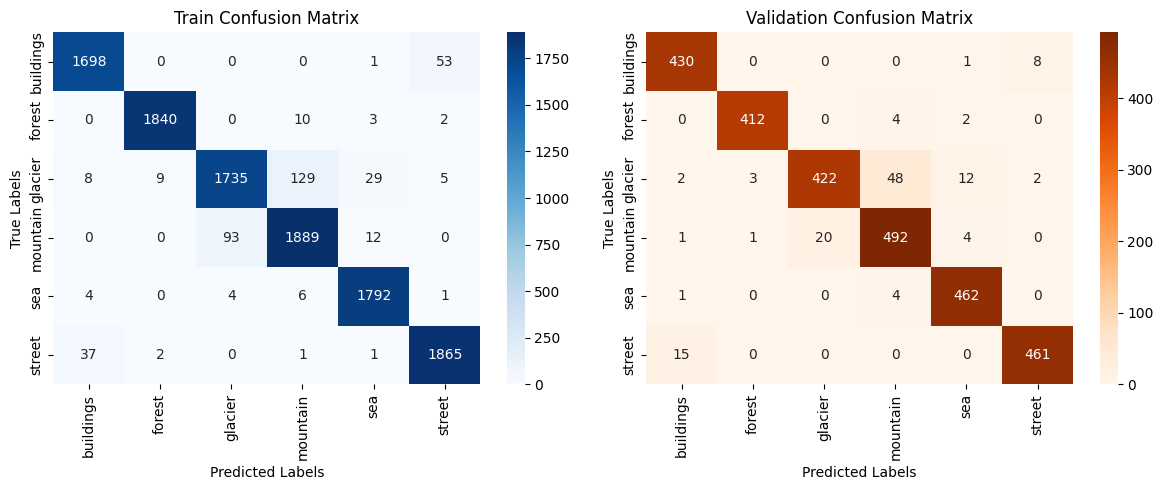

In [24]:
visualize(model, metrics)

In [28]:
light_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,), (0.5,))
])

train_ds.dataset.transform = heavy_transform

In [29]:
%%time
EPOCHS = 10
metrics2 = train_model(model, train_loader, val_loader, EPOCHS)

Epoch [1/10]: Train Loss: 0.1619, Train Acc: 0.94 | Val Loss: 0.1340, Val Acc: 0.96
Epoch [2/10]: Train Loss: 0.1538, Train Acc: 0.95 | Val Loss: 0.1340, Val Acc: 0.95
Epoch [3/10]: Train Loss: 0.1541, Train Acc: 0.95 | Val Loss: 0.1392, Val Acc: 0.95
Epoch [4/10]: Train Loss: 0.1541, Train Acc: 0.95 | Val Loss: 0.1343, Val Acc: 0.95
Epoch [5/10]: Train Loss: 0.1520, Train Acc: 0.95 | Val Loss: 0.1352, Val Acc: 0.95
Epoch [6/10]: Train Loss: 0.1537, Train Acc: 0.95 | Val Loss: 0.1365, Val Acc: 0.95
Epoch [7/10]: Train Loss: 0.1488, Train Acc: 0.95 | Val Loss: 0.1361, Val Acc: 0.95
Epoch [8/10]: Train Loss: 0.1512, Train Acc: 0.95 | Val Loss: 0.1346, Val Acc: 0.95
Epoch [9/10]: Train Loss: 0.1518, Train Acc: 0.95 | Val Loss: 0.1312, Val Acc: 0.96
Epoch [10/10]: Train Loss: 0.1531, Train Acc: 0.95 | Val Loss: 0.1380, Val Acc: 0.95
Training Complete!
CPU times: total: 17min 33s
Wall time: 28min 14s


In [30]:
metrics = list(metrics)
metrics2 = list(metrics2)
for i in range(6):
    metrics[i] = metrics[i] + metrics2[i]

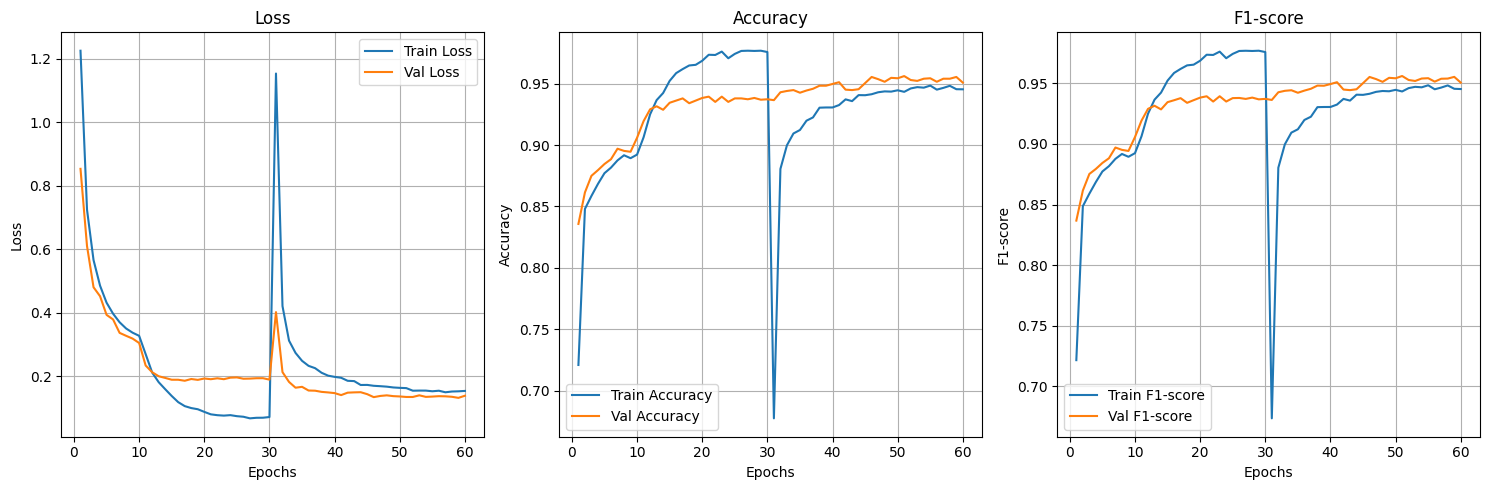

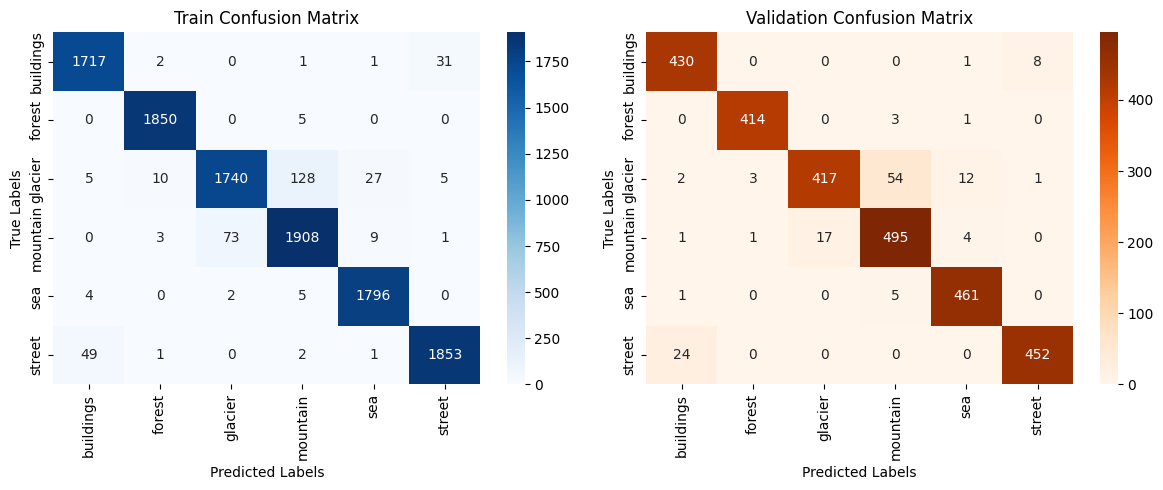

In [31]:
visualize(model, metrics)

In [32]:
y_true, y_pred = get_predictions(model, test_loader)
f1_test = f1_score(y_true, y_pred, average="weighted")
acc_test = accuracy_score(y_true, y_pred)
print(f"Test Metrics\n\naccuracy: {acc_test:.2f} | f1 score: {f1_test:.2f}")

Test Metrics

accuracy: 0.93 | f1 score: 0.93


In [16]:
def show_wrong(dataset, y_true, y_pred, n=10, class_names=None):
    wrong_indices = [i for i, (t, p) in enumerate(zip(y_true, y_pred)) if t != p]

    selected_indices = random.sample(wrong_indices, n)
    samples = [dataset[i] for i in selected_indices]
    
    images, true_labels = zip(*samples)
    pred_labels = [y_pred[i] for i in selected_indices]

    images = torch.stack(images).permute(0, 2, 3, 1).numpy()
    images = (images * 0.5 + 0.5).clip(0, 1) 

    plt.figure(figsize=(15, 6))
    for i in range(len(images)):
        plt.subplot(1, n, i + 1)
        plt.imshow(images[i])
        true_class = class_names[true_labels[i]] if class_names else true_labels[i]
        pred_class = class_names[pred_labels[i]] if class_names else pred_labels[i]
        plt.title(f"True:{true_class}\nPred:{pred_class}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()


In [20]:
y_true, y_pred = get_predictions(model, test_loader)

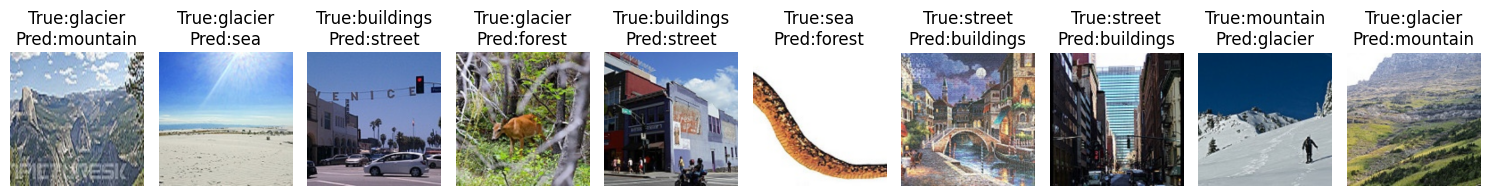

In [21]:
show_wrong(test_ds,y_true, y_pred, 10, test_ds.classes )

In [34]:
# torch.save({
#     'model_state_dict': model.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict(),
#     'metrics': metrics
# }, 'models/pretr_final.pth')